### Import Packages and Load Data

In [57]:
#!/usr/bin/env python3

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats
from statsmodels.stats.multitest import multipletests
import researchpy as rp
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from econml.dml import LinearDML
from econml.orf import DMLOrthoForest
from econml.sklearn_extensions.linear_model import WeightedLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')

# For pretty-printing arrays
import numpy as np

# Configure matplotlib for better visuals
%matplotlib inline
sns.set(style="whitegrid")

In [58]:
print("[Loading data from 'data/data.csv']")
df = pd.read_csv("data/data.csv")
df.head()

[Loading data from 'data/data.csv']


,bid2val,episodes,bid2val_std,bid2val_min,bid2val_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
0,0.95650,250000,0.016815,0.95,1.0,4,0.50,0.75,0,1,1.00,0,21,0.99990
1,1.00000,4603,0.000000,1.00,1.0,4,0.10,0.25,0,0,0.00,0,6,0.99900
2,1.00000,116248,0.000000,1.00,1.0,2,0.05,0.00,1,1,0.00,1,6,0.99995
3,0.96695,250000,0.057273,0.20,1.0,2,0.10,0.00,0,0,0.25,0,21,0.99950
4,1.00000,46050,0.000000,1.00,1.0,4,0.10,0.99,1,0,0.25,0,6,0.99990


### Exploratory Data Analysis

In [59]:
print("### Data Overview")
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
print("### Data Types")
print(df.info())

### Data Overview
Dataset contains 100 rows and 14 columns.

### Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bid2val       100 non-null    float64
 1   episodes      100 non-null    int64  
 2   bid2val_std   100 non-null    float64
 3   bid2val_min   100 non-null    float64
 4   bid2val_max   100 non-null    float64
 5   N             100 non-null    int64  
 6   alpha         100 non-null    float64
 7   gamma         100 non-null    float64
 8   egreedy       100 non-null    int64  
 9   asynchronous  100 non-null    int64  
 10  design        100 non-null    float64
 11  feedback      100 non-null    int64  
 12  num_actions   100 non-null    int64  
 13  decay         100 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 11.1 KB
None


In [60]:
print("### Descriptive Statistics")
df.describe()

### Descriptive Statistics


,bid2val,episodes,bid2val_std,bid2val_min,bid2val_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.00,100.000000,100.000000,100.000000,100.000000
mean,0.934790,154856.980000,3.928546e-02,0.687000,0.975500,3.040000,0.203400,0.535600,0.45,0.45,0.450000,0.610000,14.100000,0.999669
std,0.094827,106190.946413,5.453979e-02,0.359968,0.079929,1.004233,0.211351,0.331398,0.50,0.50,0.357107,0.490207,7.513624,0.000393
min,0.400000,4603.000000,0.000000e+00,0.000000,0.400000,2.000000,0.010000,0.000000,0.00,0.00,0.000000,0.000000,6.000000,0.999000
25%,0.906500,46050.000000,0.000000e+00,0.337500,1.000000,2.000000,0.050000,0.250000,0.00,0.00,0.000000,0.000000,6.000000,0.999500
50%,0.975725,250000.000000,2.220446e-16,0.800000,1.000000,4.000000,0.100000,0.500000,0.00,0.00,0.500000,1.000000,21.000000,0.999900
75%,1.000000,250000.000000,6.238203e-02,1.000000,1.000000,4.000000,0.500000,0.750000,1.00,1.00,0.750000,1.000000,21.000000,0.999950
max,1.000000,250000.000000,2.029645e-01,1.000000,1.000000,4.000000,0.500000,0.990000,1.00,1.00,1.000000,1.000000,21.000000,0.999990


In [61]:
print("### Missing Values in Each Column")
print(df.isnull().sum())

### Missing Values in Each Column
bid2val         0
episodes        0
bid2val_std     0
bid2val_min     0
bid2val_max     0
N               0
alpha           0
gamma           0
egreedy         0
asynchronous    0
design          0
feedback        0
num_actions     0
decay           0
dtype: int64


### Distribution of Key Variables


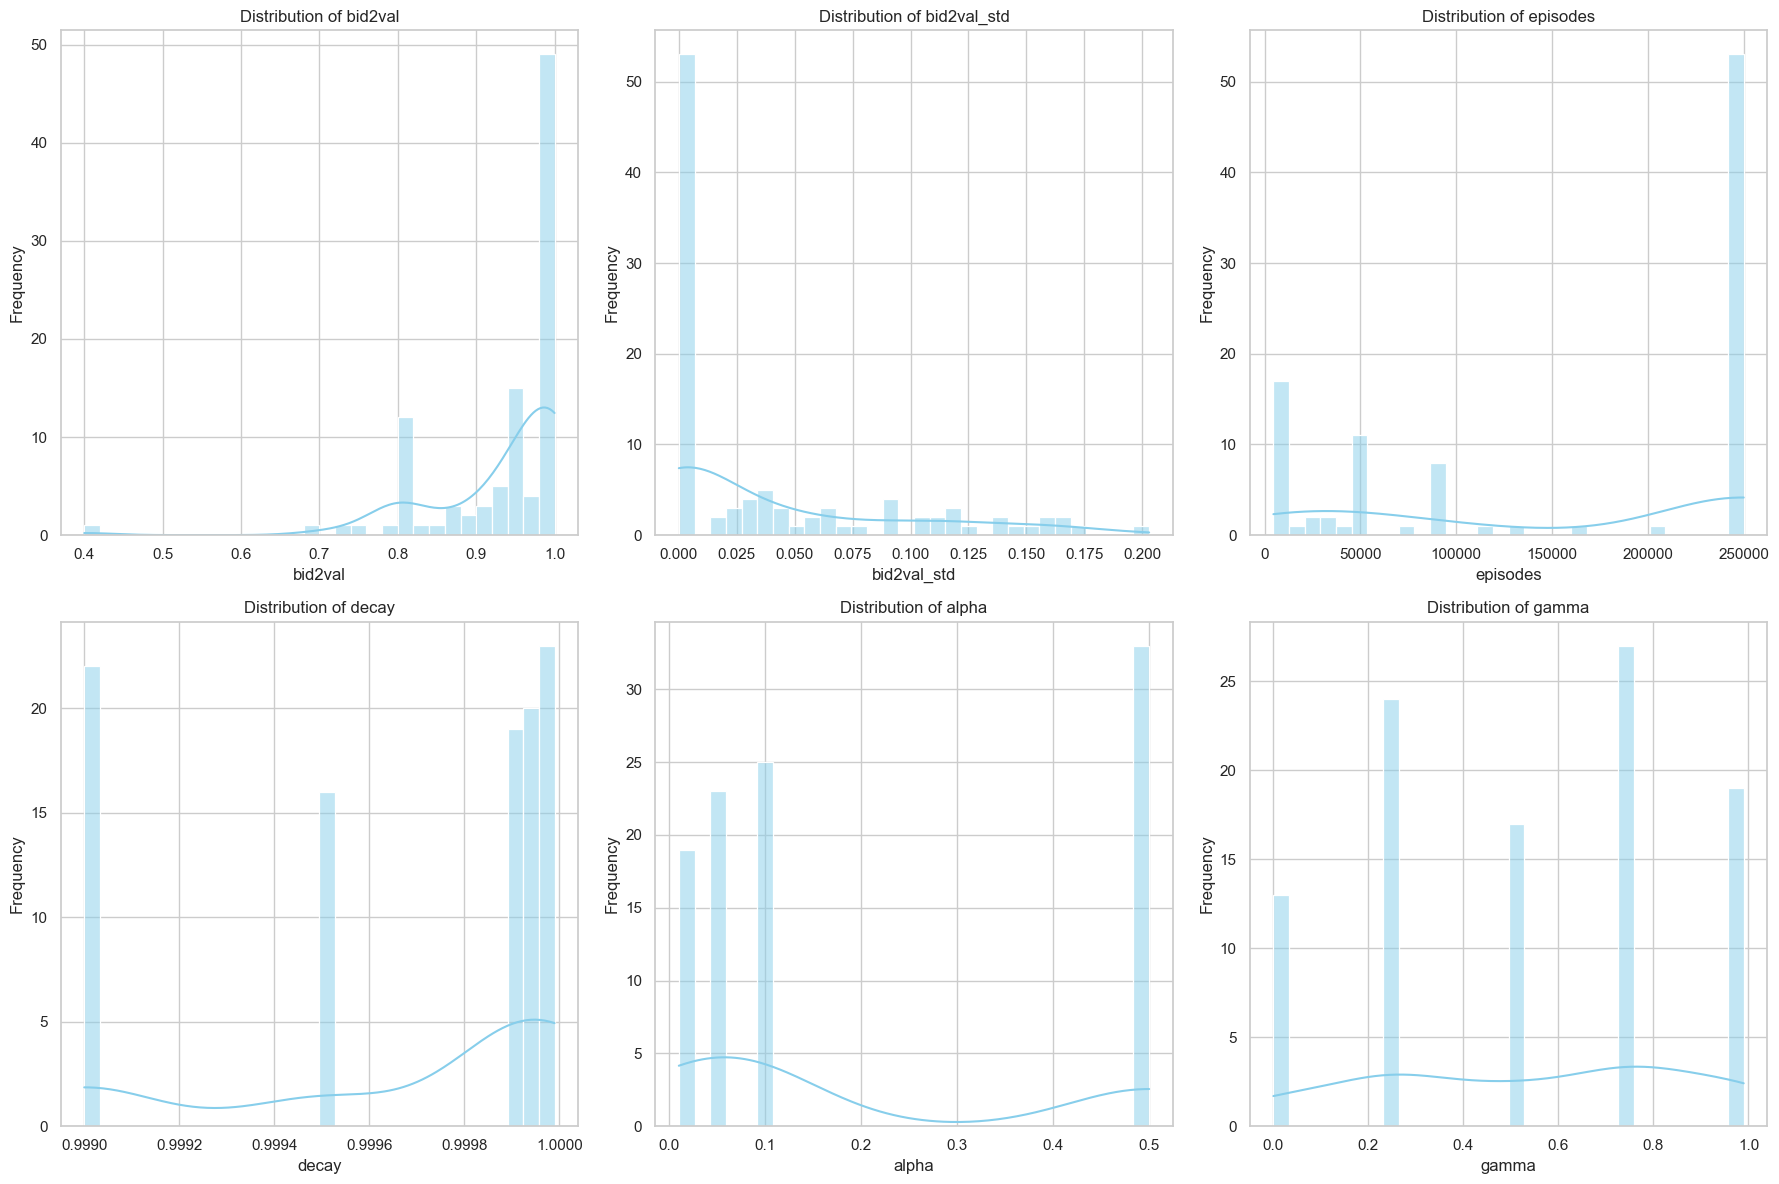

In [62]:
print("### Distribution of Key Variables")

# List of key variables to plot
key_vars = ['bid2val', 'bid2val_std', 'episodes', 'decay', 'alpha', 'gamma']

# Determine the number of rows and columns for the grid
num_vars = len(key_vars)
cols = 3
rows = num_vars // cols + int(num_vars % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, var in enumerate(key_vars):
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Distribution of {var}")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figures/distribution_key_variables_grid.png", dpi=300, bbox_inches='tight')
plt.show()

### Correlation Matrix


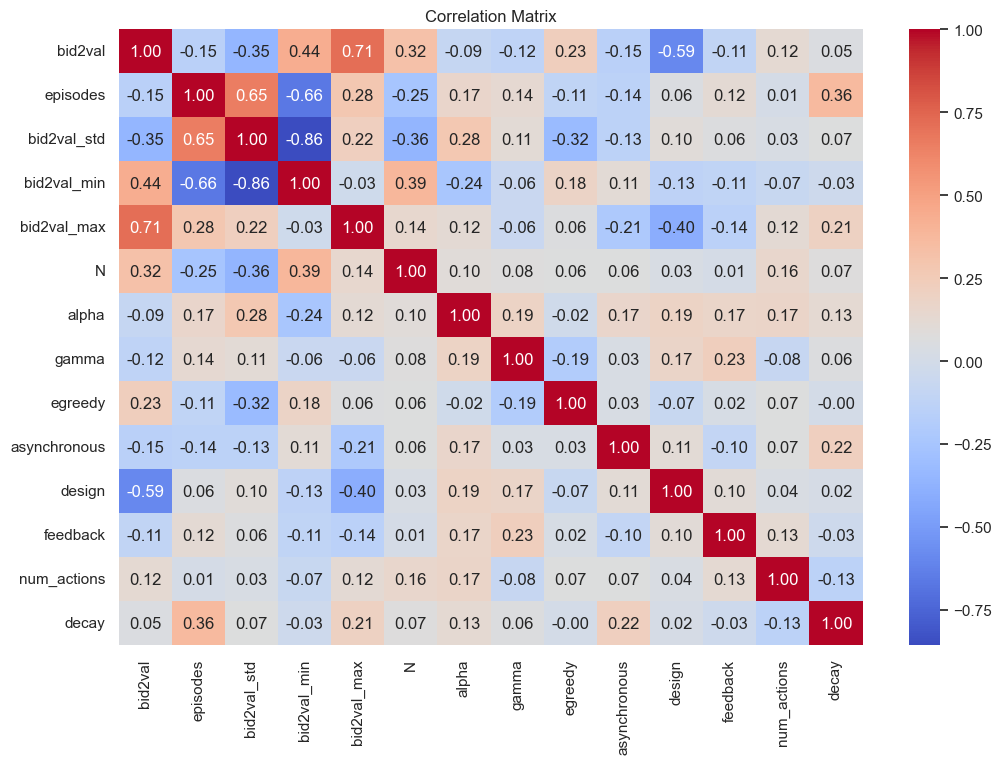

In [63]:
print("### Correlation Matrix")
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Box Plots

### Combined Boxplots: Bid-to-Valuation Metrics by Various Factors


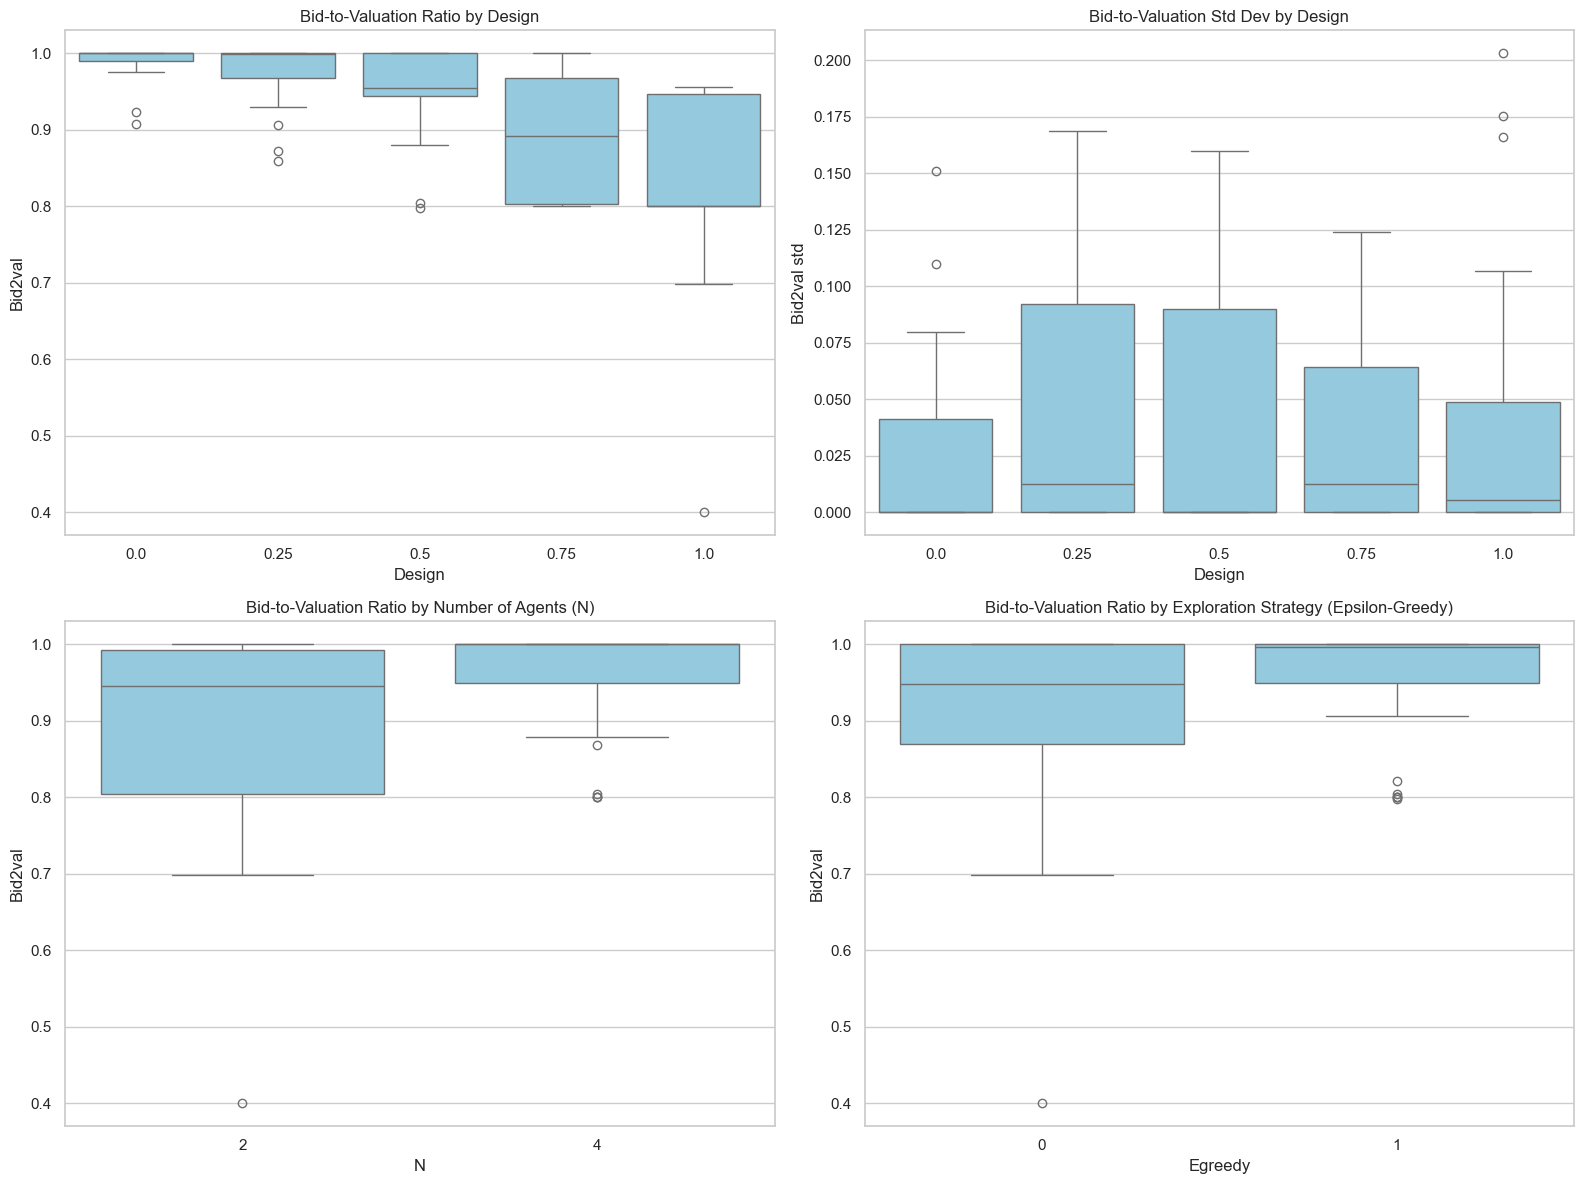

In [64]:
print("### Combined Boxplots: Bid-to-Valuation Metrics by Various Factors")

# List of tuples containing (y_variable, x_variable, title)
boxplot_configs = [
    ('bid2val', 'design', "Bid-to-Valuation Ratio by Design"),
    ('bid2val_std', 'design', "Bid-to-Valuation Std Dev by Design"),
    ('bid2val', 'N', "Bid-to-Valuation Ratio by Number of Agents (N)"),
    ('bid2val', 'egreedy', "Bid-to-Valuation Ratio by Exploration Strategy (Epsilon-Greedy)")
]

# Determine grid size based on number of plots
num_plots = len(boxplot_configs)
cols = 2
rows = num_plots // cols + int(num_plots % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, (y_var, x_var, title) in enumerate(boxplot_configs):
    sns.boxplot(data=df, x=x_var, y=y_var, ax=axes[i], color='skyblue')  # Removed palette
    axes[i].set_title(title)
    axes[i].set_xlabel(x_var.capitalize())
    axes[i].set_ylabel(y_var.replace('_', ' ').capitalize())

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figures/combined_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

### T-Tests with False Discovery Rate Correction

In [65]:
# Define treatment and outcome variables
treatment_vars = ['decay', 'alpha', 'gamma', 'N', 'egreedy', 'asynchronous', 'feedback', 'num_actions', 'design']
outcome_vars = ['bid2val', 'bid2val_std', 'episodes']

# Function to identify variable type
def get_variable_type(df, var):
    unique_vals = df[var].dropna().unique()
    return 'binary' if len(unique_vals) == 2 else 'continuous'

# Perform t-tests and collect p-values
results = []
for outcome in outcome_vars:
    for treatment in treatment_vars:
        if treatment in df.columns and outcome in df.columns:
            data = df[[treatment, outcome]].dropna()
            var_type = get_variable_type(df, treatment)
            if var_type == 'binary':
                group1 = data[data[treatment] == 0][outcome]
                group2 = data[data[treatment] == 1][outcome]
            else:
                median = data[treatment].median()
                group1 = data[data[treatment] <= median][outcome]
                group2 = data[data[treatment] > median][outcome]
            if len(group1) > 1 and len(group2) > 1:
                if group1.std() == 0 or group2.std() == 0:  # Skip identical groups
                    results.append({'Treatment': treatment, 'Outcome': outcome, 'T-statistic': None, 'P-value': None})
                else:
                    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
                    results.append({'Treatment': treatment, 'Outcome': outcome, 'T-statistic': t_stat, 'P-value': p_val})
            else:
                results.append({'Treatment': treatment, 'Outcome': outcome, 'T-statistic': None, 'P-value': None})
        else:
            results.append({'Treatment': treatment, 'Outcome': outcome, 'T-statistic': None, 'P-value': None})

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Apply FDR correction across all valid p-values
df_valid = df_results.dropna(subset=['P-value']).copy()
corrected = multipletests(df_valid['P-value'], alpha=0.05, method='fdr_bh')
df_valid['Corrected P-value'] = corrected[1]
df_valid['Significant (FDR < 0.05)'] = ['Yes' if p < 0.05 else 'No' for p in corrected[1]]

# Merge corrected results back into the main DataFrame
df_results = df_results.merge(df_valid[['Treatment', 'Outcome', 'Corrected P-value', 'Significant (FDR < 0.05)']],
                              on=['Treatment', 'Outcome'], how='left')
df_results['Corrected P-value'].fillna('N/A', inplace=True)
df_results['Significant (FDR < 0.05)'].fillna('Insufficient Data', inplace=True)

# Display results in separate tables for each outcome
for outcome in outcome_vars:
    outcome_results = df_results[df_results['Outcome'] == outcome]
    print(f"### T-test Results for Outcome: {outcome}\n")
    print(tabulate(outcome_results, headers='keys', tablefmt='github', showindex=False))
    print("\n---\n")

### T-test Results for Outcome: bid2val

| Treatment    | Outcome   |   T-statistic |       P-value | Corrected P-value     | Significant (FDR < 0.05)   |
|--------------|-----------|---------------|---------------|-----------------------|----------------------------|
| decay        | bid2val   |      0.654671 |   0.514222    | 0.5653354891891282    | No                         |
| alpha        | bid2val   |      0.79266  |   0.430314    | 0.5315648613371946    | No                         |
| gamma        | bid2val   |      0.839563 |   0.403205    | 0.5292062742660611    | No                         |
| N            | bid2val   |    nan        | nan           | N/A                   | Insufficient Data          |
| egreedy      | bid2val   |     -2.45023  |   0.0162008   | 0.06804346672932293   | No                         |
| asynchronous | bid2val   |      1.44413  |   0.153291    | 0.357677896401256     | No                         |
| feedback     | bid2val   |      1.14643  |   

### Regression Analysis

In [66]:
print("### OLS Regression: Simple Model")
est1 = smf.ols('bid2val ~ design', data=df).fit()
print(est1.summary())

### OLS Regression: Simple Model
                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     52.57
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           9.70e-11
Time:                        13:46:46   Log-Likelihood:                 115.65
No. Observations:                 100   AIC:                            -227.3
Df Residuals:                      98   BIC:                            -222.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.00

In [67]:
print("### OLS Regression: Model with Covariates")
est2 = smf.ols('bid2val ~ design + N + alpha + gamma + egreedy + asynchronous + feedback + num_actions + decay', data=df).fit()
print(est2.summary())


### OLS Regression: Model with Covariates
                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     11.12
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           1.73e-11
Time:                        13:46:51   Log-Likelihood:                 131.56
No. Observations:                 100   AIC:                            -243.1
Df Residuals:                      90   BIC:                            -217.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Interc

### Double Machine Learning Estimators

In [70]:
print("### Double Machine Learning: LinearDML")
df_ml = df.dropna()
if len(df_ml) > 1:
    y = df_ml['bid2val']
    T = df_ml['design']
    X = df_ml.drop(['bid2val', 'episodes', 'bid2val_std', 'bid2val_min',
                   'bid2val_max', 'design'], axis=1)
    
    dml_est = LinearDML()
    dml_est.fit(y, T, X=X)
    print(dml_est.summary())
else:
    print("Not enough data for Double ML analysis.")


### Double Machine Learning: LinearDML
                       Coefficient Results                        
             point_estimate stderr zstat  pvalue ci_lower ci_upper
------------------------------------------------------------------
N                     0.051  0.024  2.166   0.03    0.005    0.097
alpha                 0.077  0.103  0.754  0.451   -0.124    0.279
gamma                 0.003   0.08  0.032  0.975   -0.155     0.16
egreedy               0.058  0.045  1.271  0.204   -0.031    0.146
asynchronous         -0.053  0.056 -0.948  0.343   -0.164    0.057
feedback             -0.037  0.048 -0.777  0.437   -0.131    0.057
num_actions           0.001  0.003  0.318   0.75   -0.005    0.008
decay                76.789 72.809  1.055  0.292  -65.915  219.493
                       CATE Intercept Results                       
               point_estimate stderr zstat  pvalue ci_lower ci_upper
--------------------------------------------------------------------
cate_intercept   

### Double Machine Learning: DMLOrthoForest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished


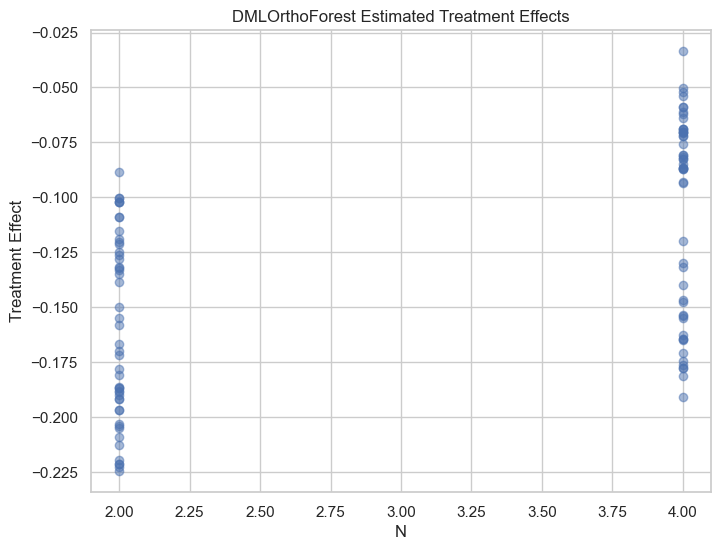

In [71]:
print("### Double Machine Learning: DMLOrthoForest")
if len(df_ml) > 1 and not X.empty:
    orf = DMLOrthoForest(n_trees=10, max_depth=4,
                         model_Y=WeightedLasso(alpha=0.01),
                         model_T=WeightedLasso(alpha=0.01),
                         random_state=123, verbose=-1)
    orf.fit(y, T, X=X)
    te = orf.effect(X)
    
    if X.shape[1] > 0:
        plt.figure(figsize=(8,6))
        plt.scatter(X.iloc[:,0], te, alpha=0.5)
        plt.title("DMLOrthoForest Estimated Treatment Effects")
        plt.xlabel(X.columns[0])
        plt.ylabel("Treatment Effect")
        plt.savefig("figures/orf_treatment_effects.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("Not enough data or features for DMLOrthoForest.")

### Random Forests

In [72]:
print("### Random Forest Regression: Predicting Episodes")
y_cv = df['episodes']
X_cv = df.drop(['bid2val', 'episodes', 'bid2val_std', 'bid2val_min', 'bid2val_max'], axis=1)

if not X_cv.empty and not y_cv.empty:
    rf = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=123)
    kf = KFold(n_splits=3, shuffle=True, random_state=123)
    scores = cross_val_score(rf, X_cv, y_cv, cv=kf, scoring='r2')
    
    print(f"Random Forest R² scores: {scores}")
    print(f"Mean R²: {scores.mean():.4f}")
    
    rf.fit(X_cv, y_cv)
    imps = rf.feature_importances_
    inds = imps.argsort()[::-1]
    
    print("\n### Feature Importances (Random Forest)")
    for i, idx in enumerate(inds):
        print(f"{i+1}. {X_cv.columns[idx]}: {imps[idx]:.4f}")
    
    perm_imp = PermutationImportance(rf).fit(X_cv, y_cv)
    print("\n### Permutation Importances")
    eli5.show_weights(perm_imp, feature_names = X_cv.columns.tolist())
else:
    print("Insufficient data for Random Forest analysis.")

### Random Forest Regression: Predicting Episodes
Random Forest R² scores: [0.23945468 0.51063733 0.44176152]
Mean R²: 0.3973

### Feature Importances (Random Forest)
1. decay: 0.5428
2. N: 0.1340
3. alpha: 0.1015
4. asynchronous: 0.0887
5. design: 0.0641
6. gamma: 0.0399
7. egreedy: 0.0159
8. num_actions: 0.0077
9. feedback: 0.0053

### Permutation Importances
